### Import packages

In [1]:
import os
import sys
import warnings

import datetime
import math
import numpy as np
import pandas as pd
import platform
import re
import subprocess
import torch as th

import gymnasium as gym
import matplotlib.pyplot as plt

from datetime import datetime
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure  # Import the configure function
from stable_baselines3.common.utils import polyak_update, set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

print(pd.__version__)
print(th.backends.mps.is_available())
print(gym.__version__)


2.2.2
True
0.29.1


### Hyperparameters

In [2]:
# Constants and Training Settings
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 50000
BATCH_SIZE = 64 * 4
TARGET_UPDATE_INTERVAL = 100
MAX_TIMESTEPS = 50000

NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256 * 2, 256])
LEARNING_STARTS = 0
TRAIN_FREQ = 4

EPSILON_START = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY_RATE = 0.00005

N_EPISODES = 5
CROSS_VAL_INTERVAL = 1

TRAINING_FOLDERS_PATH = '../data/Training/1k-3ac-12f-1dis-F/'
TESTING_FOLDERS_PATH = '../data/Testing/1k-3ac-12f-1dis-F/'

## Estimated epsilon decay

Estimated total timesteps for training: 32115
Epsilon reaches its minimum value at 0.00% of total timesteps.


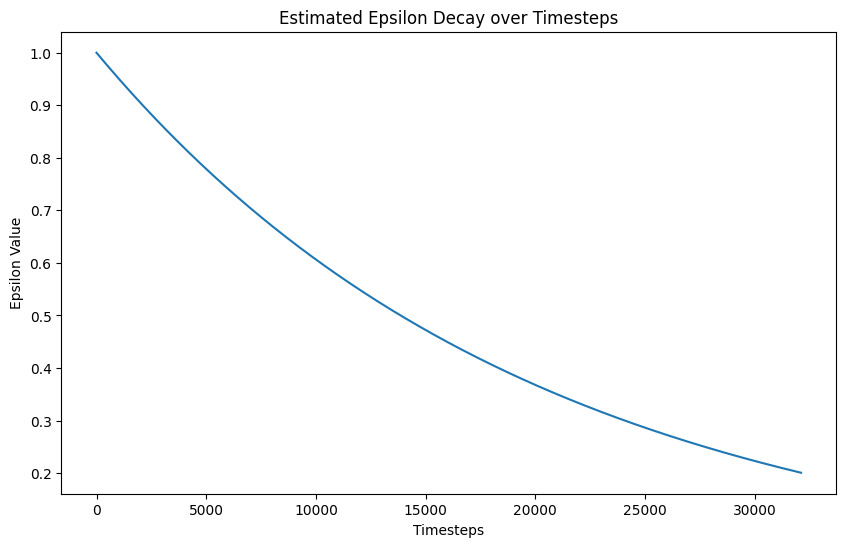

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.environment_proactive import AircraftDisruptionEnv

simulate_and_plot_epsilon_decay(
    training_folders_path=TRAINING_FOLDERS_PATH,
    n_episodes=N_EPISODES,
    epsilon_start=EPSILON_START,
    epsilon_min=EPSILON_MIN,
    epsilon_decay_rate=EPSILON_DECAY_RATE
)

In [4]:
# Initialize device
device = initialize_device()

# Check device capabilities
check_device_capabilities()

# Get device-specific information
device_info = get_device_info(device)
print(f"Device info: {device_info}")

# Verify training folders and gather training data
training_folders = verify_training_folders(TRAINING_FOLDERS_PATH)
print(f"Training folders: {training_folders}")

# Calculate training days and model naming
num_days_trained_on = calculate_training_days(N_EPISODES, training_folders)
print(f"Training on {num_days_trained_on} days of data "
        f"({N_EPISODES} episodes of {len(training_folders)} scenarios)")

formatted_days = format_days(num_days_trained_on)
last_folder = os.path.basename(os.path.normpath(TRAINING_FOLDERS_PATH))
model_name = last_folder
model_version = get_model_version(model_name)
MODEL_SAVE_PATH = f'../trained_models/{model_name}-{formatted_days}-{model_version}.zip'
print(f"Model will be saved to: {MODEL_SAVE_PATH}")

# Create results directory
results_dir = create_results_directory()
print(f"Results directory created at: {results_dir}")

Using device: mps
CUDA available: False
Number of GPUs available: 0
cuDNN enabled: True
Device: mps
Using MacBook M1
Device info: {'device_type': 'MacBook M1'}
Training folders: ['Scenario_264', 'Scenario_50', 'Scenario_432', 'Scenario_600', 'Scenario_290', 'Scenario_855', 'Scenario_899', 'Scenario_297', 'Scenario_607', 'Scenario_435', 'Scenario_57', 'Scenario_263', 'Scenario_852', 'Scenario_68', 'Scenario_638', 'Scenario_95', 'Scenario_61', 'Scenario_255', 'Scenario_631', 'Scenario_403', 'Scenario_890', 'Scenario_864', 'Scenario_404', 'Scenario_636', 'Scenario_252', 'Scenario_66', 'Scenario_92', 'Scenario_863', 'Scenario_59', 'Scenario_609', 'Scenario_897', 'Scenario_299', 'Scenario_239', 'Scenario_837', 'Scenario_662', 'Scenario_450', 'Scenario_32', 'Scenario_808', 'Scenario_206', 'Scenario_696', 'Scenario_468', 'Scenario_830', 'Scenario_691', 'Scenario_201', 'Scenario_35', 'Scenario_457', 'Scenario_665', 'Scenario_698', 'Scenario_806', 'Scenario_208', 'Scenario_495', 'Scenario_461',

# Reinforcement Learning

## Environment

In [5]:
from src.environment_proactive import AircraftDisruptionEnv



## Training

In [6]:
from src.environment_proactive import AircraftDisruptionEnv
# from src.environment_myopic import AircraftDisruptionEnv


start_time = datetime.now()

# Initialize variables
rewards = []
test_rewards = []
epsilon_values = []
total_timesteps = 0
action_sequences = {
    os.path.join(TRAINING_FOLDERS_PATH, folder): {
        "best_actions": [],
        "best_reward": float('-inf'),
        "worst_actions": [],
        "worst_reward": float('inf')
    }
    for folder in training_folders
}

# Variable to control how often cross-validation occurs
CROSS_VAL_INTERVAL = 10  # Perform cross-validation every 5 episodes

def cross_validate_on_test_data(model, current_episode):
    test_scenario_folders = [
        os.path.join(TESTING_FOLDERS_PATH, folder)
        for folder in os.listdir(TESTING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TESTING_FOLDERS_PATH, folder))
    ]
    total_test_reward = 0
    for test_scenario_folder in test_scenario_folders:
        # Load data
        data_dict = load_scenario_data(test_scenario_folder)
        aircraft_dict = data_dict['aircraft']
        flights_dict = data_dict['flights']
        rotations_dict = data_dict['rotations']
        alt_aircraft_dict = data_dict['alt_aircraft']
        config_dict = data_dict['config']

        # Update the environment with the new scenario (by reinitializing it)
        env = AircraftDisruptionEnv(
            aircraft_dict,
            flights_dict,
            rotations_dict,
            alt_aircraft_dict,
            config_dict
        )
        model.set_env(env)  # Update the model's environment with the new instance

        # Evaluate the model on the test scenario without training
        obs, _ = env.reset()

        done_flag = False
        total_reward = 0
        timesteps = 0

        while not done_flag and timesteps < MAX_TIMESTEPS:
            # Get the action mask from the environment
            action_mask = obs['action_mask']

            # Convert observation to float32
            obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

            # Preprocess observation and get Q-values
            obs_tensor = model.policy.obs_to_tensor(obs)[0]
            q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

            # Apply the action mask (set invalid actions to -inf)
            masked_q_values = q_values.copy()
            masked_q_values[action_mask == 0] = -np.inf

            # Select the action with the highest masked Q-value
            action = np.argmax(masked_q_values)

            # Take the selected action in the environment
            result = env.step(action)

            # Unpack the result
            obs_next, reward, terminated, truncated, info = result

            done_flag = terminated or truncated

            # Accumulate the reward
            total_reward += reward

            # Update the current observation
            obs = obs_next

            timesteps += 1

            if done_flag:
                break

        total_test_reward += total_reward

    # Compute average test reward
    avg_test_reward = total_test_reward / len(test_scenario_folders)
    test_rewards.append((current_episode, avg_test_reward))

def train_dqn_agent():
    # List all the scenario folders in Data/Training
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    epsilon = EPSILON_START
    global total_timesteps

    # Initialize the DQN
    dummy_scenario_folder = scenario_folders[0]
    data_dict = load_scenario_data(dummy_scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']
    env = AircraftDisruptionEnv(
        aircraft_dict,
        flights_dict,
        rotations_dict,
        alt_aircraft_dict,
        config_dict
    )

    model = DQN(
        policy='MultiInputPolicy',
        env=env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        buffer_size=BUFFER_SIZE,
        learning_starts=LEARNING_STARTS,
        batch_size=BATCH_SIZE,
        target_update_interval=TARGET_UPDATE_INTERVAL,
        verbose=0,
        policy_kwargs=NEURAL_NET_STRUCTURE,
        device=device
    )

    logger = configure()
    model._logger = logger

    # Training loop over the number of episodes
    for episode in range(N_EPISODES):
        # Cycle through all the scenario folders
        for scenario_folder in scenario_folders:
            if DEBUG_MODE_TRAINING:
                print(f"Training on scenario {scenario_folder}")

            # Load the data for the current scenario
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Reset the environment
            obs, _ = env.reset()  # Extract the observation (obs) and ignore the info (_)

            done_flag = False
            total_reward = 0
            timesteps = 0
            action_sequence = []

            while not done_flag and timesteps < MAX_TIMESTEPS:
                model.exploration_rate = epsilon

                # Get the action mask from the environment
                action_mask = obs['action_mask']

                # Convert observation to float32
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

                # Preprocess observation and get Q-values
                obs_tensor = model.policy.obs_to_tensor(obs)[0]
                q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

                # Apply the action mask (set invalid actions to -inf)
                masked_q_values = q_values.copy()
                masked_q_values[action_mask == 0] = -np.inf

                # Select an action
                if np.random.rand() < epsilon:
                    # Exploration: choose a random valid action
                    valid_actions = np.where(action_mask == 1)[0]
                    action = np.random.choice(valid_actions)
                else:
                    # Exploitation: choose the action with the highest masked Q-value
                    action = np.argmax(masked_q_values)

                # Take the selected action in the environment
                result = env.step(action)

                # Unpack the result (5 values)
                obs_next, reward, terminated, truncated, info = result

                # Combine the terminated and truncated flags into a single done flag
                done_flag = terminated or truncated

                # Store the action
                action_sequence.append(action)

                # Accumulate the reward
                total_reward += reward

                # Add the transition to the replay buffer
                model.replay_buffer.add(
                    obs=obs,
                    next_obs=obs_next,
                    action=action,
                    reward=reward,
                    done=done_flag,
                    infos=[info]
                )

                # Update the current observation
                obs = obs_next

                # Update epsilon (exploration rate)
                epsilon = max(EPSILON_MIN, epsilon * (1 - EPSILON_DECAY_RATE))
                epsilon_values.append(epsilon)

                timesteps += 1
                total_timesteps += 1

                # Training
                if total_timesteps > model.learning_starts and total_timesteps % TRAIN_FREQ == 0:
                    # Perform a training step
                    model.train(gradient_steps=1, batch_size=BATCH_SIZE)

                # Update target network
                if total_timesteps % model.target_update_interval == 0:
                    polyak_update(model.q_net.parameters(), model.q_net_target.parameters(), model.tau)
                    # Copy batch norm stats
                    polyak_update(model.batch_norm_stats, model.batch_norm_stats_target, 1.0)

                # Check if the episode is done
                if done_flag:
                    break

            # Store the total reward for the episode with the scenario specified
            rewards.append((episode, scenario_folder, total_reward))

            # Update the worst and best action sequences
            if total_reward < action_sequences[scenario_folder]["worst_reward"]:
                action_sequences[scenario_folder]["worst_actions"] = action_sequence
                action_sequences[scenario_folder]["worst_reward"] = total_reward

            if total_reward > action_sequences[scenario_folder]["best_reward"]:
                action_sequences[scenario_folder]["best_actions"] = action_sequence
                action_sequences[scenario_folder]["best_reward"] = total_reward

        # Perform cross-validation at specified intervals
        if (episode + 1) % CROSS_VAL_INTERVAL == 0:
            cross_validate_on_test_data(model, episode + 1)

        print(f"({episode + 1}/{N_EPISODES})")

    # Save the model after training
    model.save(MODEL_SAVE_PATH)

train_dqn_agent()

# Output total timesteps
print(total_timesteps)

# Output scenario action sequences and rewards
for scenario, data in action_sequences.items():
    print(f"Scenario: {scenario}, Worst Reward: {data['worst_reward']}, Best Reward: {data['best_reward']}")
    print(f"Worst Action Sequence: {data['worst_actions']}")
    print(f"Best Action Sequence: {data['best_actions']}")

    # Save the action sequences to a CSV file
    save_best_and_worst_to_csv(
        scenario,
        MODEL_SAVE_PATH,
        data['worst_actions'],
        data['best_actions'],
        data['worst_reward'],
        data['best_reward']
    )

end_time = datetime.now()
runtime = end_time - start_time
runtime_in_seconds = runtime.total_seconds()

# create new folder within results_dir called action_sequences
os.makedirs(os.path.join(results_dir, 'action_sequences'), exist_ok=True)

# Collect hyperparameters and other details
hyperparameters = {
    'LEARNING_RATE': LEARNING_RATE,
    'GAMMA': GAMMA,
    'BUFFER_SIZE': BUFFER_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'TARGET_UPDATE_INTERVAL': TARGET_UPDATE_INTERVAL,
    'EPSILON_START': EPSILON_START,
    'EPSILON_MIN': EPSILON_MIN,
    'EPSILON_DECAY_RATE': EPSILON_DECAY_RATE,
    'MAX_TIMESTEPS': MAX_TIMESTEPS,
    'LEARNING_STARTS': LEARNING_STARTS,
    'TRAIN_FREQ': TRAIN_FREQ,
    'N_EPISODES': N_EPISODES,
    'NEURAL_NET_STRUCTURE': NEURAL_NET_STRUCTURE,
    'TRAINING_FOLDERS_PATH': TRAINING_FOLDERS_PATH,
    'model_name': model_name,
    'model_version': model_version,
    'MODEL_SAVE_PATH': MODEL_SAVE_PATH,
    'runtime_in_seconds': runtime_in_seconds,
    'runtime_in_hh:mm:ss': str(runtime) if runtime_in_seconds > 0 else "0:00:00",
    'total_timesteps': total_timesteps,
    'CROSS_VAL_INTERVAL': CROSS_VAL_INTERVAL,

    # values from config.py
    'MAX_AIRCRAFT': MAX_AIRCRAFT,
    'MAX_FLIGHTS_PER_AIRCRAFT': MAX_FLIGHTS_PER_AIRCRAFT,
    'TIMESTEP_HOURS': TIMESTEP_HOURS,
    'DUMMY_VALUE': DUMMY_VALUE,
    'RESOLVED_CONFLICT_REWARD': RESOLVED_CONFLICT_REWARD,
    'DELAY_MINUTE_PENALTY': DELAY_MINUTE_PENALTY,
    'MAX_DELAY_PENALTY': MAX_DELAY_PENALTY,
    'NO_ACTION_PENALTY': NO_ACTION_PENALTY,
    'CANCELLED_FLIGHT_PENALTY': CANCELLED_FLIGHT_PENALTY,
    'MIN_TURN_TIME': MIN_TURN_TIME,

    # device info
    'device': device,
    'device_info': device_info

}

# Save hyperparameters to CSV
hyperparameters_df = pd.DataFrame(list(hyperparameters.items()), columns=['Parameter', 'Value'])
hyperparameters_df.to_csv(os.path.join(results_dir, 'hyperparameters.csv'), index=False)

# Save the action sequences to CSV files in the results directory
for scenario, data in action_sequences.items():
    scenario_name = os.path.basename(scenario)
    worst_actions_df = pd.DataFrame(data['worst_actions'], columns=['Action'])
    best_actions_df = pd.DataFrame(data['best_actions'], columns=['Action'])
    worst_actions_df.to_csv(os.path.join(results_dir, 'action_sequences', f'{scenario_name}_worst_actions.csv'), index=False)
    best_actions_df.to_csv(os.path.join(results_dir, 'action_sequences', f'{scenario_name}_best_actions.csv'), index=False)


Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-11-16-20-55-50-406597
(1/5)


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated input
print(f"num_days_trained_on {num_days_trained_on}")
rewards_per_day = len(rewards) // num_days_trained_on

# Print out the structure of the rewards list
print(f"Trained on {num_days_trained_on} days of data ({len(training_folders)} unique scenarios)")

# Process training rewards per episode
episode_rewards = {}
for episode, scenario_folder, total_reward in rewards:
    if episode not in episode_rewards:
        episode_rewards[episode] = []
    episode_rewards[episode].append(total_reward)

avg_rewards_per_episode = []
episodes = []
for episode in sorted(episode_rewards.keys()):
    avg_reward = np.mean(episode_rewards[episode])
    avg_rewards_per_episode.append(avg_reward)
    episodes.append(episode + 1)  # episode numbers start from 0, so add 1

# Extract test rewards
test_episodes = [ep for ep, _ in test_rewards]
test_avg_rewards = [reward for _, reward in test_rewards]

# Plot the average rewards over the episodes
plt.figure(figsize=(12, 6))
plt.plot(episodes, avg_rewards_per_episode, label='Training Average Reward')

# Plot test rewards
plt.plot(test_episodes, test_avg_rewards, label='Test Average Reward', marker='o', linestyle='--')

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode')
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_episode.png'))
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize a dictionary to store rewards for each scenario
scenario_rewards = defaultdict(list)

# Iterate through the rewards list and group by scenario (last two characters)
for _, scenario, reward in rewards:
    scenario_id = scenario[-2:]  # Get the last two characters (e.g., '01', '02', etc.)
    scenario_rewards[scenario_id].append(reward)

# calculate the average reward for each scenario
avg_rewards_per_batch_per_scenario = {scenario: np.mean(rewards) for scenario, rewards in scenario_rewards.items()}
sorted_scenarios = sorted(avg_rewards_per_batch_per_scenario.keys())

# Extract the sorted average rewards
sorted_avg_rewards_per_batch = [avg_rewards_per_batch_per_scenario[scenario] for scenario in sorted_scenarios]

# Plot a bar chart with scenarios on the x-axis and average rewards on the y-axis
plt.figure(figsize=(10, 6))
plt.bar(sorted_scenarios, sorted_avg_rewards_per_batch)
plt.xlabel('Scenario')
plt.ylabel('Average Reward')
plt.title('Average Reward per Scenario')
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_scenario.png'))
plt.close()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create the new folder within results_dir
scenario_results_dir = os.path.join(results_dir, 'plots', 'reward-plots-per-scenario')
os.makedirs(scenario_results_dir, exist_ok=True)

# Iterate over all scenarios in scenario_rewards
for scenario_id, rewards_list in scenario_rewards.items():
    # Set the smoothing window (adjust the size as needed)
    window = 1000
    # Ensure the window size does not exceed the length of the rewards list
    if len(rewards_list) < window:
        window = len(rewards_list)
    smoothed_rewards = np.convolve(rewards_list, np.ones(window) / window, mode='same')

    plt.figure()
    plt.plot(rewards_list, label='Reward')
    plt.plot(smoothed_rewards, label='Smoothed Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward per Episode for Scenario ' + scenario_id)
    plot_filename = f'average_reward_for_scenario_{scenario_id}.png'
    plt.savefig(os.path.join(scenario_results_dir, plot_filename))
    plt.close()

In [ ]:
print("total_timesteps", total_timesteps)
# Plot the epsilon values over the episodes 10, 6
plt.figure(figsize=(10, 6))
plt.plot(range(len(epsilon_values)), epsilon_values)
plt.xlabel('Timesteps')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Value over Timesteps')
plt.savefig(os.path.join(results_dir, 'plots', 'epsilon_value_over_timesteps.png'))
plt.show()